# Using OpenAI Client to invoke Holo1 for a navigation task

Holo1 is an Action Vision-Language Model (VLM) developed by [H Company](https://www.hcompany.ai/) for use in the Surfer-H web agent system. It is designed to interact with web interfaces like a human user. 

As part of a broader agentic architecture, Holo1 acts as a policy, localizer, or validator, helping the agent understand and act in digital environments.

This notebook demonstrates how to call Holo1 (3B or 7B) using OpenAI Client.

## Prerequisites

Before running this notebook, ensure you have:

- Holo1 served with vLLM (see the [deploy recipe](https://github.com/hcompai/hai-cookbook/blob/main/holo1/vllm/README.md))

## Contents

1. [Install required python dependencies](#1-install-required-python-dependencies)
3. [Prepare the Input Payload](#3-prepare-the-input-payload)
4. [Invoke Holo1 endpoint](#4-invoke-holo1-endpoint)
5. [Invoke Holo1 endpoint with structured output](#5-invoke-holo1-endpoint-with-structured-output)


## Contents

1. [Install required python dependencies](#1-install-required-python-dependencies)
2. [Prepare the Input Payload](#2-prepare-the-input-payload)
3. [Invoke Holo1 endpoint with structured output](#3-invoke-sagemaker-endpoint-with-structured-output)



## 1. Install required python dependencies

In [ ]:
%pip install -qU rich openai pydantic Pillow

In [1]:
import json
#import rich
import re

from typing import Any, Literal
from PIL import Image
import pathlib as pl
import sys
from IPython.display import display

In [3]:
# Add directory to the Python path to import utils package
project_root_dir = pl.Path.cwd().resolve().parents[1]
sys.path.append(str(project_root_dir))

In [2]:
# Get cursor .png path
cursor_img_path = "cursor_image_red.png"

## 2. Prepare the Input Payload

Holo1 models are served using vLLM as an OpenAI Server. 

In this example, Holo1 is prompted to book an hotel on a given date.

**Important**: The input image must be resized using Qwen’s `smart_resize` method. This is crucial because vLLM performs its own internal resizing, which can alter the original image dimensions and lead to inaccurate or misaligned coordinate predictions from the model.

In [44]:
# Prepare inference request
from image import smart_resize

# Load image
image_path = "calendar_example.jpg"
image = Image.open(image_path)

# Resize the image so that predicted absolute coordinates match the size of the image.
resized_height, resized_width = smart_resize(height=image.height, width=image.width)
image = image.resize(size=(resized_width, resized_height), resample=None)

## 3. Invoking Holo1 via API with structured output

In [6]:
from navigation import *
from datetime import datetime

def build_navigation_task_messages(
    task: str, image: Image.Image, image_format: str, step: int = 1
) -> list[dict[str, Any]]:
    system_prompt = SYSTEM_PROMPT.format(
        output_format=NavigationStep.model_json_schema(),
        timestamp=datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    )
    image_url = convert_image_to_base64_url(image, image_format)
    return [
        {
            "role": "system",
            "content": [
                {"type": "text", "text": system_prompt},
            ],
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": f"<task>\n{task}\n</task>\n"},
                {"type": "text", "text": f"<observation step={step}>\n"},
                {"type": "text", "text": "<screenshot>\n"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": image_url,
                    },
                },
                {"type": "text", "text": "\n</screenshot>\n"},
                {"type": "text", "text": "\n</observation>\n"},
            ],
        },
    ]

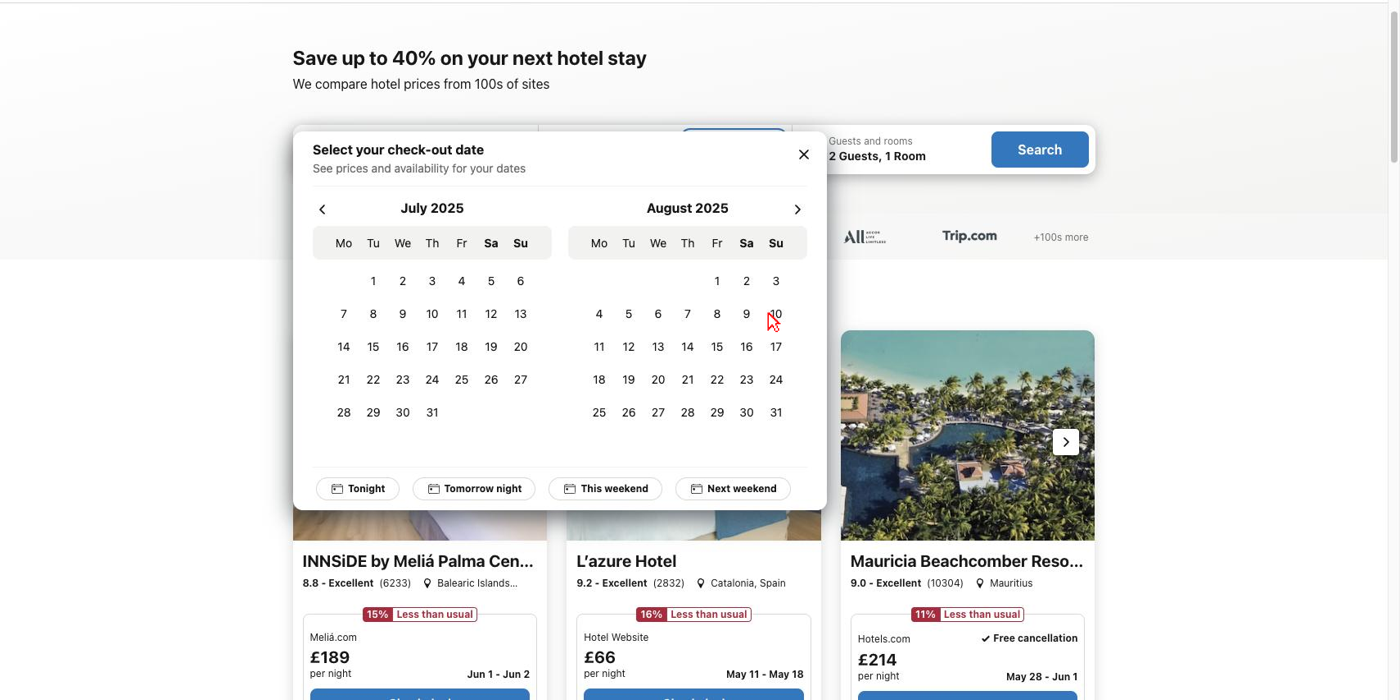

note='Calendar open showing July and August 2025.' thought='Need to select check-in date as August 17, 2025.' action=ClickAbsoluteAction(action='click_absolute', x=773, y=318)


In [48]:
from openai import OpenAI
from image import draw_image_with_click
from navigation import NavigationStep

MODEL_NAME = "Hcompany/Holo1.5-7B"
BASE_URL = "http://34.7.85.95:8000/v1"
API_KEY = "EMPTY"

client = OpenAI(
    base_url=BASE_URL,
    api_key=API_KEY
)

chat_completion = client.chat.completions.create(
    model=MODEL_NAME,
    messages=build_navigation_task_messages(
        image=image,
        task="Book a hotel in Paris on August 17 for 3 nights",
        image_format="JPEG",
    ),
    temperature=0,
    extra_body={
        "guided_json": NavigationStep.model_json_schema(),
    }
)

navigation_step = NavigationStep(**json.loads(chat_completion.choices[0].message.content))
display(draw_image_with_click(image, navigation_step.action.x, navigation_step.action.y, cursor_img_path))

print(navigation_step)